In [1]:
from PIL import Image
import numpy as np
from scipy.stats import multivariate_normal
from matplotlib import pyplot as plt
from functools import reduce
from random import randint
import math
from numba import jit, float32

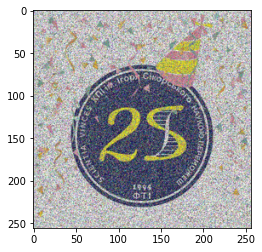

 img shape (256, 256, 3)


In [2]:
# load the image
image = Image.open('ipt.png').resize((256, 256))
plt.imshow(image)
plt.show()

# convert image to numpy array (256, 256, 3)
img_tenzor = np.asarray(image)
# summarize shape
print(f' img shape {img_tenzor.shape}')

In [10]:
@jit(nopython=True)        
def norm_pdf_multivariate(x, mu, sigma):
    size = len(x)
    if size == len(mu) and (size, size) == sigma.shape:
        det = np.linalg.det(sigma)
        if det == 0:
            raise NameError("The covariance matrix can't be singular")

        norm_const = 1.0/ (math.pow((2*math.pi),float(size)/2) * math.pow(det,1.0/2) )
        x_mu = x - mu
        inv = np.linalg.inv(sigma)         
        result = math.pow(math.e, -0.5 * ((x_mu).dot(inv).dot(x_mu.T)))
        return norm_const * result
    else:
        raise NameError("The dimensions of the input don't match")
        
        
        
@jit(nopython=True)
def likelyhood(pixel_color_list,  mu1, cov1, mu2, cov2):
    
    pdf_1 = norm_pdf_multivariate(pixel_color_list, mu1, cov1)
    pdf_2 = norm_pdf_multivariate(pixel_color_list,  mu2, cov2)
    
    return randint(0, 1), pdf_1, pdf_2 
   

In [11]:
@jit(nopython=True)
def expectation(img_tenzor, p_k1, p_k2, mu1, mu2, cov1, cov2, shape):
    
    alpha_matrix  = np.zeros(shape=(*shape, 2), dtype=float32)
    pk_matrix = np.zeros(shape=(*shape, 2), dtype=float32)
    alpha_1_sum = 0
    alpha_2_sum = 0  
    for i in range(shape[0]):
        for j in range(shape[1]):
            _, like_1, like_2 = likelyhood(img_tenzor[i][j], mu1, cov1, mu2, cov2)
            numerator1, numerator2 = (p_k1*like_1), (p_k2*like_2)
            alpha_1, alpha_2 = numerator1/(numerator1+numerator2), numerator2/(numerator1+numerator2)
            alpha_matrix[i][j] = alpha_1, alpha_2
            alpha_1_sum += alpha_1
            alpha_2_sum += alpha_2
            p_k1 = alpha_1_sum/(shape[0]*shape[1])
            p_k2 = alpha_2_sum/(shape[0]*shape[1])
    
        
    return alpha_matrix, alpha_1_sum, alpha_2_sum, p_k1, p_k2

In [12]:
@jit(nopython=True)
def maximization(img_tensor, alpha_matrix, alpha_1_sum, alpha_2_sum, mu1, mu2, cov1, cov2, length):
    for r in range(length):
        mu1[r] = np.sum(alpha_matrix[:, :, 0]*img_tenzor[:, :, r])/alpha_1_sum
        mu2[r] = np.sum(alpha_matrix[:, :, 1]*img_tenzor[:, :, r])/alpha_2_sum
        for s in range(length):
            cov1[r, s] = np.sum(alpha_matrix[:, :, 0]*(img_tenzor[:, :, r]-mu1[r])*(img_tenzor[:, :, s]-mu1[s]))/alpha_1_sum
            cov2[r, s] = np.sum(alpha_matrix[:, :, 1]*(img_tenzor[:, :, r]-mu2[r])*(img_tenzor[:, :, s]-mu2[s]))/alpha_2_sum
    return mu1, mu2, cov1, cov2

In [13]:
@jit(nopython=True)
def find_neighbors(matrix, i, j):
    neighbors = [matrix[i+step[0], j+step[1], 0] for step in
                      [(0,-1), (0,1), (-1,0), (1,0)] 
                    if ((0 <= i+step[0] < len(matrix)) and (0 <= j+step[1] < len(matrix[0])))]
    return neighbors


@jit(nopython=True)
def sampling(matrix, eps, shape):
    
    new_matrix = np.zeros(shape=shape, dtype=float32)
    for i in range(shape[0]):
        for j in range(shape[1]):
            neighbors = find_neighbors(matrix, i, j)
            k1 = matrix[i,j][1]*reduce(lambda a, b: a*b,[(1 - eps) if x == 1 else eps for x in neighbors])
            k2 = matrix[i,j][2]*reduce(lambda a, b: a*b,[(1 - eps) if x == 0 else eps for x in neighbors])
            prob_k1, prob_k2 = k1/(k1+k2), k2/(k1+k2)
            new_matrix[i,j,0] = (1 if prob_k1 > prob_k2 else 0)
            new_matrix[i,j,1:]= prob_k1, prob_k2
    return new_matrix

In [14]:

def EM_fit(img_tenzor, em_iters=100):
    shape = img_tenzor.shape
    p_k1 = 1/2.
    p_k2 = 1/2.
    mu1 = np.array([50,50,50], dtype=np.float64)
    mu2 = np.array([200,170,200], dtype=np.float64)
    cov1 = np.array([[10**2,2**2,2**2], [2**2, 10**2, 2**2],[2**2, 2**2, 10**2]], dtype=np.float64)
    cov2 = np.array([[10**2,2**2,2**2], [2**2, 10**2, 2**2],[2**2, 2**2, 10**2]], dtype=np.float64)

    for iteration in range(em_iters):
        alpha_matrix, alpha_1_sum, alpha_2_sum, p_k1, p_k2 = expectation(img_tenzor, p_k1, p_k2, mu1, mu2, cov1, cov2, shape[:2])
        mu1, mu2, cov1, cov2 = maximization(img_tenzor, alpha_matrix, alpha_1_sum, alpha_2_sum, mu1, mu2, cov1, cov2, shape[2])
    return ((mu1, cov1), (mu2, cov2), (p_k1, p_k2))   

        
    
def EM_predict(img_tenzor, params_1, params_2, sampling_iters=100, eps = 0.2 ):

    shape = img_tenzor.shape
    matrix = np.zeros(shape=shape, dtype=float)
    for i in range(shape[0]):
        for j in range(shape[1]):
            matrix[i, j] = likelyhood(img_tenzor[i][j],  *params_1, *params_2)

    for i in range(sampling_iters):
        matrix = sampling(matrix, 0.2, shape)
        
    return matrix[:, :, 0]
#         if i % 20 == 0:
#             plt.imshow(matrix[:, :, 0])
#             plt.show()


class probabilities:  (0.23868812069140485, 0.7613118793086072)

 class 1 params:
[67.10455965 71.36060403 99.14392189]
[[592.6543635  290.16122261 171.39071923]
 [290.16122261 558.74645043 161.71787268]
 [171.39071923 161.71787268 375.49606848]]

 class 2 params:
[184.74317142 182.54195558 175.53643074]
[[ 936.74536419  626.04196363  562.37269751]
 [ 626.04196363 1001.2369959   665.59064249]
 [ 562.37269751  665.59064248 1706.08355088]]


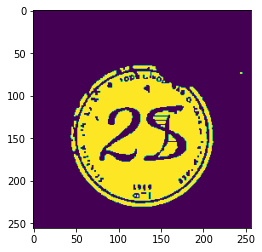

CPU times: user 1min 9s, sys: 299 ms, total: 1min 10s
Wall time: 1min 13s


In [17]:
%%time


params_1, params_2, probabilities  = EM_fit(img_tenzor, 100)
print(f'class probabilities:  {probabilities}')
print('\n class 1 params:', *params_1, sep='\n')
print('\n class 2 params:', *params_2, sep='\n')
marked_image_data = EM_predict(img_tenzor, params_1, params_2, 100, 0.2)


plt.imshow(marked_image_data)
plt.show()